Allele frequency of 67 SNPs that vary significantly between control and at least one treatment group, indicating substrain selection or de novo SNP acquisition.

In [47]:
library(matrixStats)
library(OligoMMR2)
library(ComplexHeatmap)
library(gtools)

In [54]:
ht_opt(heatmap_column_names_gp = gpar(fontface = "italic"), 
    heatmap_column_title_gp = gpar(fontsize = 10),
    legend_border = "black",
    heatmap_border = TRUE,
    annotation_border = TRUE
)

In [55]:
oligomm_ab_wgs_imputed_wide <- readRDS("../datasets/omm_wgs_imputed_wide_filtered.rds") 

In [56]:
effect_size_threshold <- 0.1
p_threshold <- 0.001
af_threshold <- 0
count_threshold <- 8
mouse_ids <- c("1683", "1688", "1692", "1699")
col_fun <- circlize::colorRamp2(c(0, 0.5, 1), c("white", "orange", "red"))

In [57]:
df_wide_bug <- as.data.frame(oligomm_ab_wgs_imputed_wide)
df_wide_bug <- df_wide_bug[which(df_wide_bug$p_ciprofloxacin <= p_threshold |
                                   df_wide_bug$p_tetracyclin <= p_threshold |
                                   df_wide_bug$p_vancomycin <= p_threshold ),]
dim(df_wide_bug)
df_wide_bug <- df_wide_bug[which(df_wide_bug$effect_size_ciprofloxacin >= effect_size_threshold |
                                   df_wide_bug$effect_size_ciprofloxacin >= effect_size_threshold |
                                   df_wide_bug$effect_size_ciprofloxacin >= effect_size_threshold ),]
dim(df_wide_bug)
df_wide_bug <- df_wide_bug[which(df_wide_bug$observations_vancomycin >= count_threshold &
                                   df_wide_bug$observations_tetracyclin >= count_threshold &
                                   df_wide_bug$observations_control >= count_threshold &
                                   df_wide_bug$observations_ciprofloxacin >= count_threshold ),]
dim(df_wide_bug)

[1] 141 135

[1]  73 135

[1]  71 135

In [58]:
# order by genome and position 
df_wide_bug <- df_wide_bug[order(df_wide_bug$chr, df_wide_bug$POS), ]
# get SNP statistics we can use for filtering later
# split in annot and data
df_wide_bug_mat <- df_wide_bug[,  grep("16", colnames(df_wide_bug))]
annot <- df_wide_bug[, grep("16", colnames(df_wide_bug), invert = T)]
# subset for relevant mouse ids
limited_mat <- df_wide_bug_mat[, which(substr(colnames(df_wide_bug_mat), 1, 4) %in% mouse_ids)]
rownames(limited_mat) <- paste0(annot$feature, "-",  annot$POS)
# Again filter for SNPs that are present in these mice
keep <- which(rowSums(limited_mat > 0, na.rm = T) > 0)
limited_mat <- limited_mat[keep,]
annot <- annot[keep,]

In [59]:
orders <- data.frame(
  day = as.integer(substr(colnames(limited_mat), 6, 7)),
  mouse = substr(colnames(limited_mat), 1, 4))
orders <- transform(orders,
                    mouse = factor(mouse, labels = mouse_ids))

orders2 <- orders[with(orders, order(mouse, day)), ]
sample_id_in_order <- paste0(orders2$mouse, "-", orders2$day)

In [60]:
day_annot_1 <- ifelse(binDaysByPhase(
  as.integer(substr(colnames(limited_mat),
                    6, 7))) == "post-treatment", "*", "")
day_annot_1[which(
  translateMouseIdToTreatmentGroup(substr(colnames(limited_mat),
                                          1, 4)) == "Control")] <- "" # Reset arrows for control
day_annot_2 <- as.integer(substr(colnames(limited_mat), 6, 7))

# Annotation columns - should be in the order matched limited_mat
col_fun_ha <- circlize::colorRamp2(c(0, max(day_annot_2)), c("white", "grey50"))
column_ha <- ComplexHeatmap::HeatmapAnnotation(day = anno_simple(day_annot_2,
                                                 col = col_fun_ha,
                                                 pch = day_annot_1,
                                                 height = unit(.4, "cm"),
                                                 border = TRUE),
                               annotation_name_gp = gpar(fontsize = 6))

# row_ha <- list(type = c("coding" = "black", "non-coding" = "gey10", "hypothetical" = "gey50"))
row_ha_col <- c("coding" = "black", "non-coding" = "white", "hypothetical" = "grey50")

annot_function_simple <- as.character(as.matrix(annot$feature))
annot_function_simple[which(annot_function_simple != "hypothetical protein" &
                              annot_function_simple != "outside ORFs")] <- "coding"
annot_function_simple <- annot_function_simple %>%
  replace(. == "hypothetical protein", "hypothetical") %>%
  replace(. == "outside ORFs", "non-coding") %>%
  replace(. == "coding", "coding") # rename

row_ha <- ComplexHeatmap::rowAnnotation(type = anno_simple(annot_function_simple,
                                           border = TRUE,
                                           simple_anno_size = unit(.2, "cm"),
                                           col = row_ha_col
))

row_titles_occ <- as.data.frame(table(annot$feature))
row_titles_occ <- row_titles_occ[order(-row_titles_occ$Freq), ]
row_titles_occ <- row_titles_occ[which(row_titles_occ$Var1 != "hypothetical protein" & row_titles_occ$Var1 != "outside ORFs"), ]
row_titles_occ_frequent <- as.character(as.matrix(row_titles_occ[which(row_titles_occ$Freq >= 5), ]$Var1))

row_titles <- unique(annot$feature)
row_titles[which(row_titles == "outside ORFs")] <- ""
row_titles[which(row_titles == "hypothetical protein")] <- ""
row_titles[which(!row_titles %in% row_titles_occ_frequent)] <- ""
annot$p_tetracyclin_star <- gtools::stars.pval(annot$p_tetracyclin)

sig_ha_col_p_ciprofloxacin <- c("sig" = "white", "non-sig" = "white")
sig_ha_col_p_p_tetracyclin <- c("sig" = "white", "non-sig" = "white")
sig_ha_col_p_vancomycin <- c("sig" = "white", "non-sig" = "white")

pch_num <- 20
sig_ha <- ComplexHeatmap::rowAnnotation(Ciprofloxacin = ComplexHeatmap::anno_simple(ifelse(annot$p_ciprofloxacin < 0.05, "sig", "non-sig"),
                                            pch = ifelse(annot$p_ciprofloxacin < 0.05, pch_num, NA),
                                            border = TRUE,
                                            pt_size = unit(1, "mm"),
                                            col = sig_ha_col_p_ciprofloxacin,
                                            simple_anno_size = unit(.2, "cm")),
                        Tetracyclin = anno_simple(ifelse(annot$p_tetracyclin < 0.05, "sig", "non-sig"),
                                          pch = ifelse(annot$p_tetracyclin < 0.05, pch_num, NA),
                                          border = TRUE,
                                          pt_size = unit(1, "mm"),
                                          col = sig_ha_col_p_p_tetracyclin,
                                          simple_anno_size = unit(.2, "cm")),
                        Vancomycin = anno_simple(ifelse(annot$p_vancomycin < 0.05, "sig", "non-sig"),
                                            pch = ifelse(annot$p_vancomycin < 0.05, pch_num, NA),
                                            border = TRUE,
                                            pt_size = unit(1, "mm"),
                                            col = sig_ha_col_p_vancomycin,
                                            simple_anno_size = unit(.2, "cm")),
                        annotation_name_gp = gpar(fontsize = 6))

snp_ids <- paste0(annot$chr,"-" ,annot$POS, "-",annot$ALT, "-", annot$REF)
# iso_data <- iso_data[which(iso_data$AF > 0.8),]
##oligomm_ab_isolates$snp_ids <- paste0(oligomm_ab_isolates$chr,"-" ,
##                                      oligomm_ab_isolates$POS, "-", 
 ##                                     oligomm_ab_isolates$REF,"-",
  ##                                    oligomm_ab_isolates$ALT)

##in_iso <- ifelse(snp_ids %in% oligomm_ab_isolates$snp_ids == TRUE,
  ##               "in_isolates", "not_in_isolates")
##sig_ha_col_in_iso <- c("in_isolates" = "white", "not_in_isolates" = "white")

In [61]:
df <- data.frame(chr = annot$chr, pos = annot$POS, phage = FALSE)

In [62]:
dim(limited_mat)
length(annot$chr)

[1] 71 64

[1] 71

In [53]:
write.table(limited_mat, "Figure_2_data.tsv", sep = "\t", quote = F)
write.table(annot, "Figure_2_data_pval.tsv", sep = "\t", quote = F)

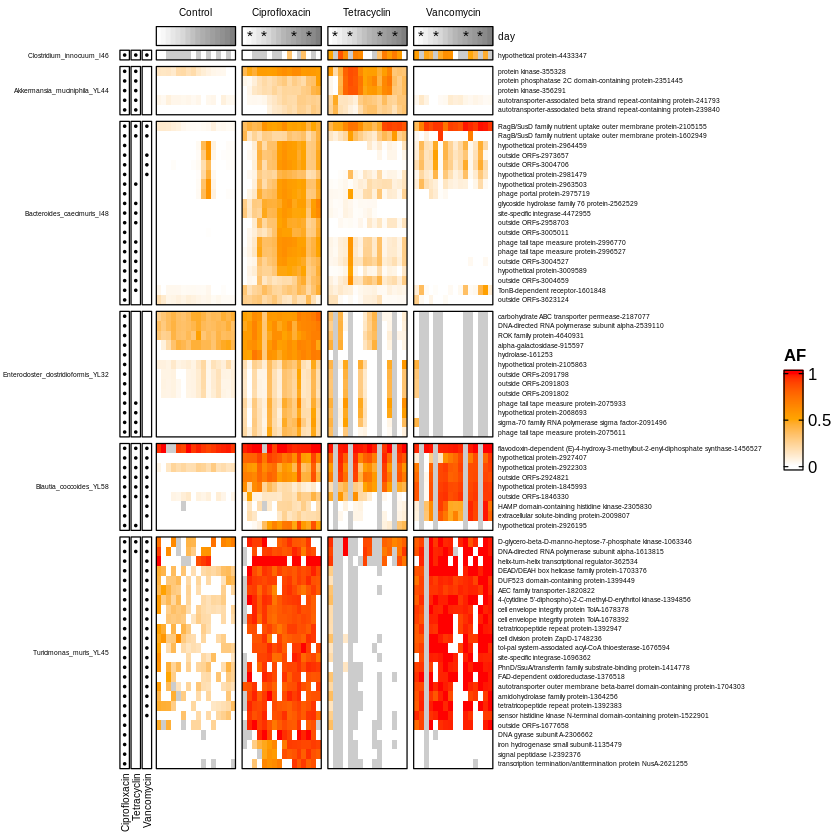

In [63]:
ht <- ComplexHeatmap::Heatmap(data.matrix(limited_mat),
                              name = "AF",
                              left_annotation = sig_ha,
                              na_col = "grey80",
                              cluster_rows = T,
                              row_gap = unit(1.4, "mm"),
                              row_split = annot$chr,
                              row_title_rot = 0,
                              row_title_gp = gpar(fontsize = 4),
                              top_annotation = column_ha,
                              col = col_fun,
                              column_split = factor(translateMouseIdToTreatmentGroup(substr(colnames(limited_mat), 1, 4)),
                                                    levels = c("Control", "Ciprofloxacin", "Tetracyclin", "Vancomycin")
                              ),
                              column_gap = unit(1.4, "mm"),
                              gap = unit(0, "mm"),
                              cluster_columns = F,
                              border_gp = gpar(col = "black", lty = 1),
                              show_row_dend = F,
                              show_column_names = F,
                              column_title_gp = gpar(fontsize = 6),
                              column_names_gp = gpar(fontsize = 3),
                              show_row_names = T,
                              row_names_gp = gpar(fontsize = 4)
                            #                        col = c(rep("black", 71)
                             )
ht

In [64]:
pdf("Figure2.pdf", width = 7, height = 5.2)
print(ht)
dev.off()

png 
  2